In [29]:
from pathlib import Path
import os

ENABLE_VISION = True

ROOT = Path.cwd().resolve()
IMG_PATH = ROOT.parent / "inputs" / "0116.jpg"
OUT_DIR  = ROOT.parent / "outputs" / "single"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# jawne ustawienie w kernelu
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(Path.home() / "secrets" / "vision-key.json")

cred = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS", "")
assert cred and Path(cred).expanduser().exists(), f"Brak klucza: {cred}"

if ENABLE_VISION:
    from google.cloud import vision
    vision_client = vision.ImageAnnotatorClient()
    with open(IMG_PATH, "rb") as f:
        gimg = vision.Image(content=f.read())

print("Ready:", {"vision": ENABLE_VISION, "img": str(IMG_PATH), "out": str(OUT_DIR)})

Ready: {'vision': True, 'img': '/home/wysokozaawansowany_gmail_com/work/MetaLogic/inputs/0116.jpg', 'out': '/home/wysokozaawansowany_gmail_com/work/MetaLogic/outputs/single'}


In [30]:
from google.cloud import vision

# progi
LABEL_THR = 0.60
OBJ_THR   = 0.60

labels = vision_client.label_detection(image=gimg).label_annotations
objects = vision_client.object_localization(image=gimg).localized_object_annotations

label_tags  = [l.description.lower() for l in labels if l.score >= LABEL_THR]
object_tags = [o.name.lower() for o in objects if o.score >= OBJ_THR]

# pudełka do podglądu
boxes = [
    (o.name.lower(), [(v.x, v.y) for v in o.bounding_poly.normalized_vertices])
    for o in objects if o.score >= OBJ_THR
]

print("labels:", label_tags[:15])
print("objects:", object_tags[:15])

labels: ['outerwear', 'jacket', 'monochrome photography', 'monochrome', 'coat', 'customer', 'market', 'black and white', 'overcoat', 'retail']
objects: ['pants', 'person', 'person', 'coat', 'person', 'person', 'person', 'person', 'outerwear', 'coat']


In [31]:
text_ann = vision_client.text_detection(image=gimg).text_annotations
texts = []
if text_ann:
    texts = [t.description.strip().lower() for t in text_ann[1:] if len(t.description.strip())>=3]
    texts = [t for t in texts if any(ch.isalpha() for ch in t)]
print("texts:", texts[:20])

texts: ['drob', 'bity', 'mrożony']


In [32]:
import pandas as pd

tags = sorted(set(label_tags + object_tags + texts))

rows = []
rows.append(("", "pl", "en", "universal"))
rows.append(("Title","Ulica z szyldami","Street photo with shop signs",""))
rows.append(("Description","Widok ulicy z ludźmi i szyldami.","Street view with people and text signs.",""))
for t in tags:
    rows.append(("Subject","",t,""))

OUT_DIR.mkdir(parents=True, exist_ok=True)
out_csv = OUT_DIR / "import_dlibra.csv"
pd.DataFrame(rows).to_csv(out_csv, index=False, header=False, encoding="utf-8")
print("saved:", out_csv)

saved: /home/wysokozaawansowany_gmail_com/work/MetaLogic/outputs/single/import_dlibra.csv


In [33]:
from PIL import Image, ImageDraw

img = Image.open(IMG_PATH).convert("RGB")
w, h = img.size
draw = ImageDraw.Draw(img)
for name, verts in boxes:
    pts = [(int(x*w), int(y*h)) for x,y in verts]
    draw.line(pts + [pts[0]], width=2)
out_img = OUT_DIR / "preview_boxes.jpg"
img.save(out_img)
print("saved:", out_img)

saved: /home/wysokozaawansowany_gmail_com/work/MetaLogic/outputs/single/preview_boxes.jpg


### Summary


LABELS (10):
 • black and white
 • coat
 • customer
 • jacket
 • market
 • monochrome
 • monochrome photography
 • outerwear
 • overcoat
 • retail

OBJECTS (4):
 • coat
 • outerwear
 • pants
 • person

TEXTS (3):
 • bity
 • drob
 • mrożony

Miniatura z boxami: /home/wysokozaawansowany_gmail_com/work/MetaLogic/outputs/single/summary_preview.jpg


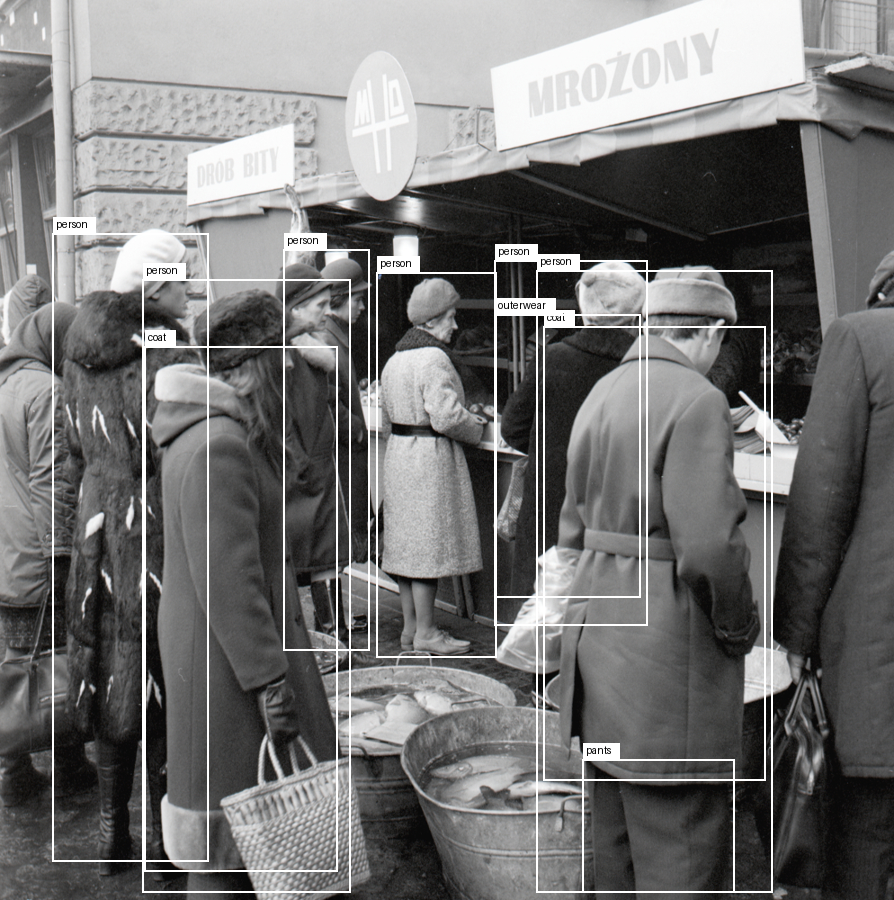

In [34]:
# --- Podsumowanie: ładny wydruk + miniatura z boxami ---
from collections import Counter
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import textwrap

# Zbierz źródła (użyj zmiennych z wcześniejszych komórek)
labels_list  = sorted(set(label_tags)) if 'label_tags' in globals() else []
objects_list = sorted(set(object_tags)) if 'object_tags' in globals() else []
texts_list   = sorted(set(texts))       if 'texts' in globals() else []

# Zbuduj boxy, jeśli nie ma wcześniej
if 'boxes' not in globals() and 'objects' in globals():
    boxes = [
        (o.name.lower(), [(v.x, v.y) for v in o.bounding_poly.normalized_vertices])
        for o in objects
    ]

# Wydruk sekcji
def print_section(title, items, max_items=50):
    print(f"\n{title} ({len(items)}):")
    for t in items[:max_items]:
        print(" •", t)

print_section("LABELS", labels_list)
print_section("OBJECTS", objects_list)
print_section("TEXTS", texts_list)

# Miniatura z boxami
thumb = (900, 900)  # docelowa dłuższa krawędź
img = Image.open(IMG_PATH).convert("RGB")
w, h = img.size
scale = min(thumb[0]/w, thumb[1]/h)
nw, nh = int(w*scale), int(h*scale)
img_res = img.resize((nw, nh))

draw = ImageDraw.Draw(img_res)
for name, verts in (boxes or []):
    pts = [(int(x*nw), int(y*nh)) for x,y in verts]
    if len(pts) >= 2:
        draw.line(pts + [pts[0]], width=2)
        # podpis w lewym górnym rogu boxa
        x0, y0 = pts[0]
        draw.rectangle([x0, y0-16, x0+6*len(name)+6, y0], fill=(255,255,255))
        draw.text((x0+3, y0-15), name, fill=(0,0,0))

out_img = OUT_DIR / "summary_preview.jpg"
img_res.save(out_img)
print(f"\nMiniatura z boxami: {out_img}")
display(img_res)